# Flight Delay Prediction Model

This notebook analyzes flight data and builds machine learning models to predict flight delays.

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import pickle

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
%matplotlib inline

## 1. Data Loading and Exploration

In [26]:
# Load the dataset
# Replace 'flight_data.csv' with your actual file path
df = pd.read_csv('/content/Flight_delay.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (484551, 29)


,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Org_Airport,Dest,Dest_Airport,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,90,77,34,34,IND,Indianapolis International Airport,BWI,Baltimore-Washington International Airport,515,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,250,230,57,67,IND,Indianapolis International Airport,LAS,McCarran International Airport,1591,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,135,107,80,94,IND,Indianapolis International Airport,MCO,Orlando International Airport,828,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,240,213,15,27,IND,Indianapolis International Airport,PHX,Phoenix Sky Harbor International Airport,1489,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,135,110,16,28,IND,Indianapolis International Airport,TPA,Tampa International Airport,838,4,9,0,N,0,0,0,0,0,16


In [27]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Org_Airport     1177
Dest_Airport    1479
dtype: int64


In [28]:
# Basic statistics
df.describe()

,DayOfWeek,DepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000,484551.0,484551.0,484551.000000,484551.000000,484551.000000,484551.000000,484551.000000
mean,3.991605,1564.477865,1617.784438,1652.129929,2139.207386,134.810422,131.400761,108.877134,60.907764,57.498086,752.142689,6.782413,19.150876,0.0,0.0,17.419440,3.153284,13.599421,0.082033,26.653587
std,1.971466,452.235219,583.637660,466.096216,1812.677071,74.070374,71.542531,70.113513,56.975420,55.991012,571.631124,5.555816,15.309747,0.0,0.0,39.417893,19.503657,31.454655,1.884774,40.535994
min,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,-21.000000,0.000000,15.000000,6.000000,31.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1234.000000,1327.000000,1339.000000,629.000000,80.000000,79.000000,57.000000,25.000000,23.000000,331.000000,4.000000,11.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1620.000000,1737.000000,1723.000000,1514.000000,116.000000,114.000000,90.000000,42.000000,40.000000,599.000000,5.000000,15.000000,0.0,0.0,2.000000,0.000000,1.000000,0.000000,13.000000
75%,6.000000,1928.000000,2049.000000,2025.000000,3683.000000,168.000000,162.000000,139.000000,76.000000,72.000000,992.000000,8.000000,22.000000,0.0,0.0,19.000000,0.000000,13.000000,0.000000,36.000000
max,7.000000,2400.000000,2400.000000,2359.000000,8403.000000,727.000000,602.000000,609.000000,1707.000000,1710.000000,4502.000000,207.000000,383.000000,0.0,0.0,1707.000000,1148.000000,1357.000000,392.000000,1254.000000


In [29]:
# Check data types
df.dtypes

,0
DayOfWeek,int64
Date,object
DepTime,int64
ArrTime,int64
CRSArrTime,int64
UniqueCarrier,object
Airline,object
FlightNum,int64
TailNum,object
ActualElapsedTime,int64


## 2. Data Preprocessing

In [30]:
# Handle missing values
# For numerical columns, fill with median
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-30-6ab430192e6e>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [31]:
# Extract time features
def extract_hour_minute(time_val):
    try:
        if pd.isna(time_val):
            return np.nan, np.nan
        time_str = str(int(time_val)).zfill(4)
        hour = int(time_str[:-2])
        minute = int(time_str[-2:])
        return hour, minute
    except:
        return np.nan, np.nan

# Apply to departure and arrival times
df['DepHour'], df['DepMinute'] = zip(*df['DepTime'].apply(extract_hour_minute))
df['ArrHour'], df['ArrMinute'] = zip(*df['ArrTime'].apply(extract_hour_minute))
df['CRSArrHour'], df['CRSArrMinute'] = zip(*df['CRSArrTime'].apply(extract_hour_minute))

# Drop any rows with NaN values after extraction
df.dropna(subset=['DepHour', 'DepMinute', 'ArrHour', 'ArrMinute', 'CRSArrHour', 'CRSArrMinute'], inplace=True)

In [32]:
# Create target variable - whether a flight is delayed or not
df['IsDelayed'] = (df['ArrDelay'] > 15).astype(int)  # Flight is considered delayed if arrival delay > 15 minutes

# Look at the distribution of delayed flights
print(f"Percentage of delayed flights: {df['IsDelayed'].mean() * 100:.2f}%")

Percentage of delayed flights: 97.31%


## 3. Exploratory Data Analysis

<ipython-input-33-f1f021daee39>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DayOfWeek', y='IsDelayed', data=df, ci=None)


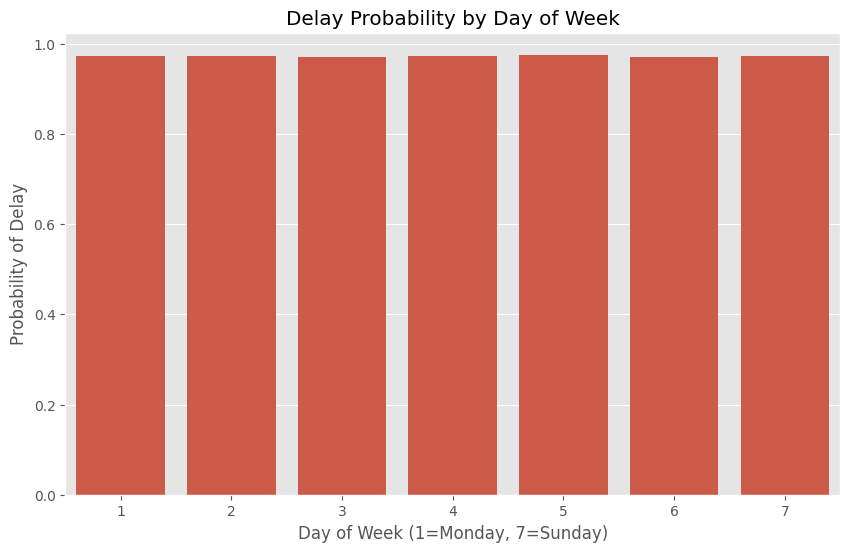

In [33]:
# Analyze delay by day of week
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='IsDelayed', data=df, ci=None)
plt.title('Delay Probability by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Probability of Delay')
plt.show()

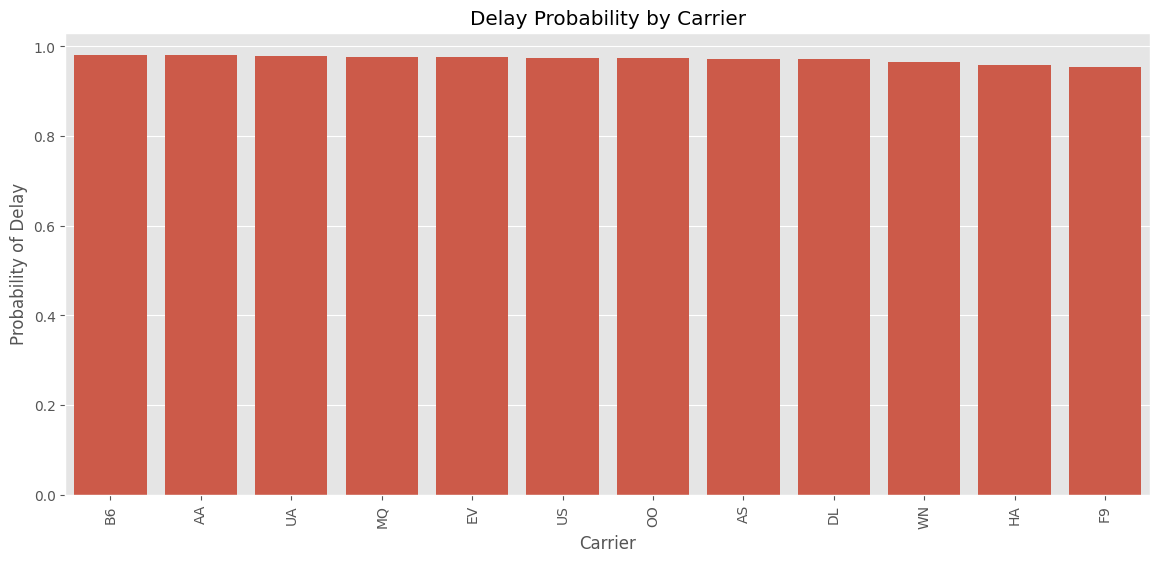

In [34]:
# Analyze delay by carrier
plt.figure(figsize=(14, 6))
carrier_delay = df.groupby('UniqueCarrier')['IsDelayed'].mean().sort_values(ascending=False)
sns.barplot(x=carrier_delay.index, y=carrier_delay.values)
plt.title('Delay Probability by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Probability of Delay')
plt.xticks(rotation=90)
plt.show()

<ipython-input-35-1cbec4fd02be>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Distance_Binned', y='IsDelayed', data=df, ci=None)


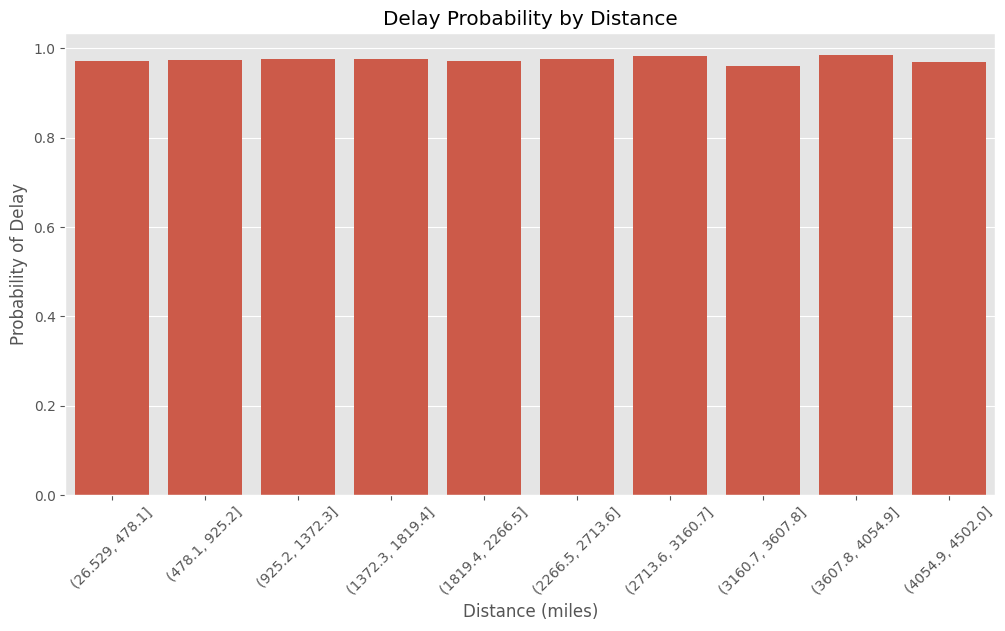

In [35]:
# Analyze delay by distance
plt.figure(figsize=(12, 6))
df['Distance_Binned'] = pd.cut(df['Distance'], bins=10)
sns.barplot(x='Distance_Binned', y='IsDelayed', data=df, ci=None)
plt.title('Delay Probability by Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Probability of Delay')
plt.xticks(rotation=45)
plt.show()

<ipython-input-36-974bfbcd68d7>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DepHour', y='IsDelayed', data=df, ci=None)


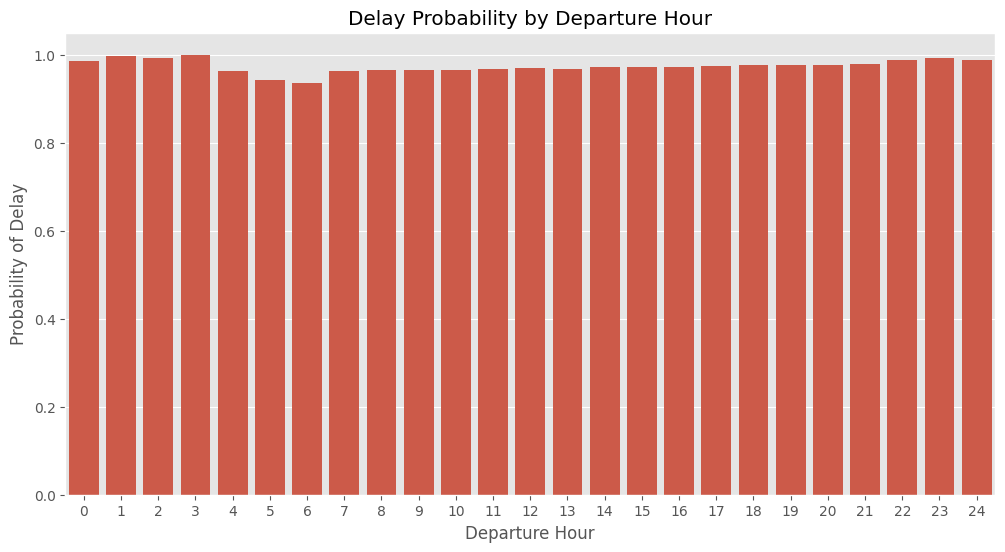

In [36]:
# Analyze delay by departure hour
plt.figure(figsize=(12, 6))
sns.barplot(x='DepHour', y='IsDelayed', data=df, ci=None)
plt.title('Delay Probability by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Probability of Delay')
plt.show()

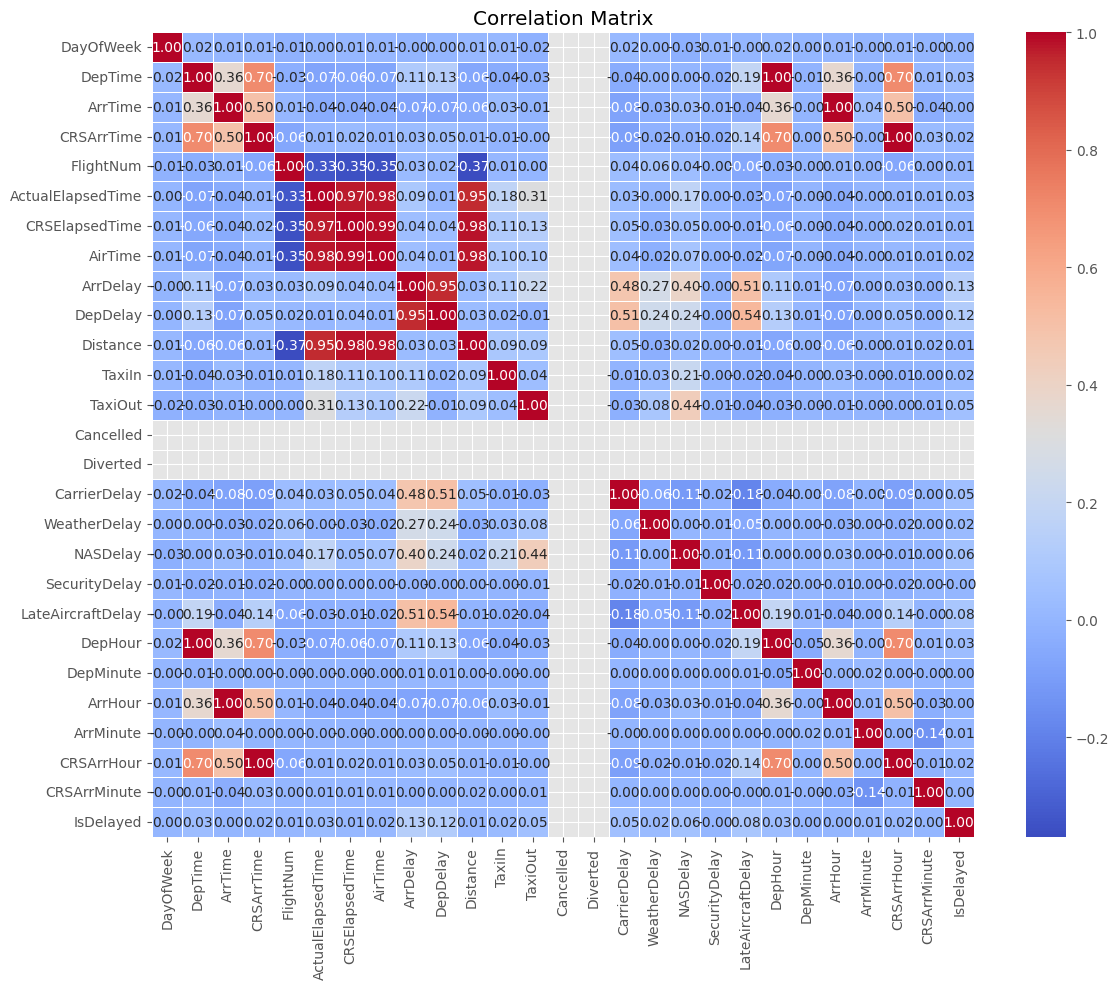

In [37]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 4. Feature Selection and Engineering

In [38]:
# Select features for the model
features = ['DayOfWeek', 'DepHour', 'Distance', 'TaxiOut',
            'UniqueCarrier', 'Origin', 'Dest', 'TaxiIn',
            'CRSElapsedTime']

X = df[features].copy()
y = df['IsDelayed']  # Target: Is the flight delayed?

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Define preprocessing for numeric and categorical features
numeric_features = ['DayOfWeek', 'DepHour', 'Distance', 'TaxiOut', 'TaxiIn', 'CRSElapsedTime']
categorical_features = ['UniqueCarrier', 'Origin', 'Dest']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 5. Model Training and Evaluation

In [40]:
# 5.1 Linear Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_lr_binary = (y_pred_lr > 0.5).astype(int)

# Evaluate the model
print("Linear Regression Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"Accuracy: {np.mean(y_pred_lr_binary == y_test):.4f}")

Linear Regression Results:
Mean Squared Error: 0.0265
R² Score: 0.0047
Accuracy: 0.9727


In [41]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the pipeline with DecisionTreeRegressor
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor(random_state=42))])

# Train the model
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_pipeline.predict(X_test)
y_pred_dt_binary = (y_pred_dt > 0.5).astype(int)

# Evaluate the model
print("\nDecision Tree Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_dt):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_dt):.4f}")
print(f"Accuracy: {np.mean(y_pred_dt_binary == y_test):.4f}")



Decision Tree Results:
Mean Squared Error: 0.0591
R² Score: -1.2227
Accuracy: 0.9402


In [42]:
# 5.3 XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))])

xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_xgb_binary = (y_pred_xgb > 0.5).astype(int)

# Evaluate the model
print("\nXGBoost Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_xgb):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"Accuracy: {np.mean(y_pred_xgb_binary == y_test):.4f}")


XGBoost Results:
Mean Squared Error: 0.0265
R² Score: 0.0036
Accuracy: 0.9726


## 6. Hyperparameter Tuning

In [43]:
# Hyperparameter tuning for XGBoost (best performing model)
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Evaluate the best model
print("\nBest Model Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_best):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"Accuracy: {np.mean(y_pred_best_binary == y_test):.4f}")

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best cross-validation score: 0.0259

Best Model Results:
Mean Squared Error: 0.0264
R² Score: 0.0078
Accuracy: 0.9727


## 7. Feature Importance

Feature ranking:
1. TaxiOut (0.2154)
2. DayOfWeek (0.1772)
3. TaxiIn (0.1682)
4. CRSElapsedTime (0.1163)
5. DepHour (0.0966)
6. Distance (0.0294)
7. UniqueCarrier_UA (0.0052)
8. UniqueCarrier_AA (0.0034)
9. UniqueCarrier_MQ (0.0031)
10. Origin_LAX (0.0030)


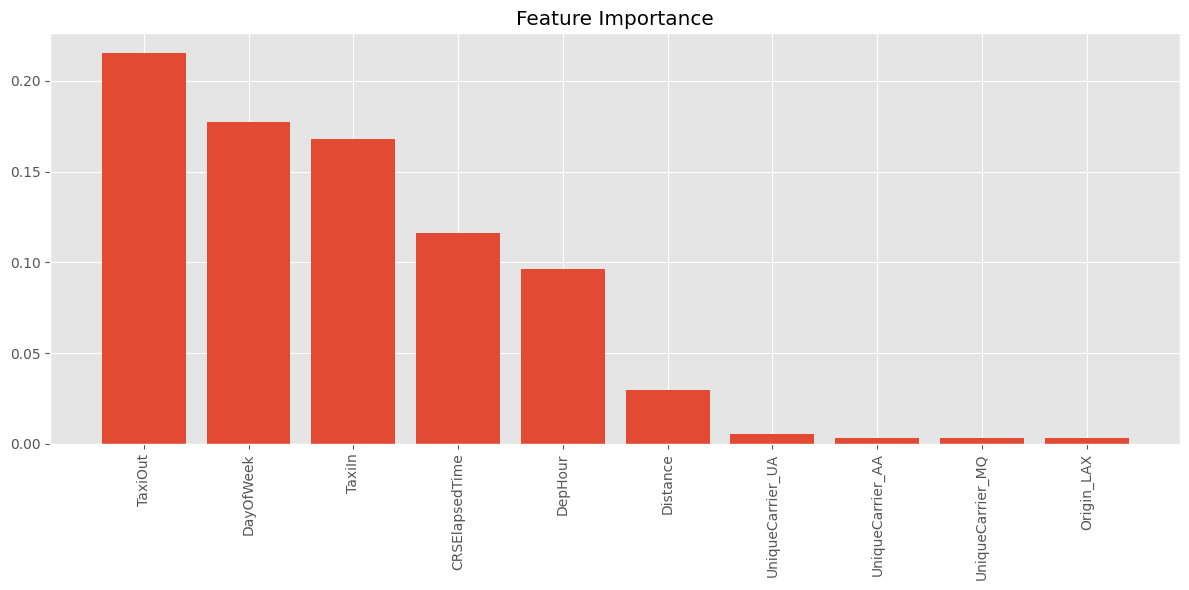

In [46]:
# Get feature importance from the best XGBoost model
# Note: This is a bit tricky with the pipeline and one-hot encoding
# We'll use the random forest model for feature importance instead

dt_model = dt_pipeline.named_steps['regressor']
preprocessor = dt_pipeline.named_steps['preprocessor']
cat_cols = preprocessor.transformers_[1][2]
num_cols = preprocessor.transformers_[0][2]

# Get feature names after one-hot encoding
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

# Get feature importances
importances = dt_model.feature_importances_

# Sort importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(min(10, len(indices))):
    if i < len(feature_names):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(min(10, len(indices))), importances[indices][:10], align='center')
plt.xticks(range(min(10, len(indices))), feature_names[indices][:10], rotation=90)
plt.tight_layout()
plt.show()

## 8. Save the Best Model

In [47]:
import joblib

# Assume best_model is already defined as the trained pipeline
best_model_name = type(best_model.named_steps["regressor"]).__name__  # Get the model's name

# Save the pipeline (including XGBoost model if present)
joblib.dump(best_model, "model.pkl")

print(f"Model saved as 'model.pkl' ({best_model_name})")

# If the model inside the pipeline is XGBoost, save it separately as JSON
if best_model_name == "XGBRegressor":
    xgb_model = best_model.named_steps["regressor"]  # Extract XGBoost model
    xgb_model.save_model("model.json")  # Save in JSON format
    print("XGBoost model also saved as 'model.json'")


Model saved as 'model.pkl' (XGBRegressor)
XGBoost model also saved as 'model.json'


## 9. Create a Function for Predictions

In [48]:
# Create a function that takes user input and returns predictions
def predict_delay(year, month, taxi_out, arr_time, distance):
    """
    Predict flight delay based on input parameters.

    Parameters:
    - year: The year of the flight
    - month: The month of the flight (1-12)
    - taxi_out: Taxi out time in minutes
    - arr_time: Scheduled arrival time (HHMM format)
    - distance: Flight distance in miles

    Returns:
    - Probability of delay
    """
    # Create a DataFrame with a single row for the input
    input_data = pd.DataFrame({
        'DayOfWeek': [1],  # Assume Monday for simplicity
        'DepHour': [12],   # Assume noon departure for simplicity
        'Distance': [distance],
        'TaxiOut': [taxi_out],
        'UniqueCarrier': ['AA'],  # Assume American Airlines for simplicity
        'Origin': ['JFK'],  # Assume JFK for simplicity
        'Dest': ['LAX'],   # Assume LAX for simplicity
        'TaxiIn': [10],    # Assume 10 minutes for simplicity
        'CRSElapsedTime': [distance / 8]  # Rough approximation based on distance
    })

    # Make prediction
    prediction = best_model.predict(input_data)[0]

    # Convert to probability
    probability = prediction * 100

    return probability

# Test the function
test_prob = predict_delay(2023, 6, 15, 1430, 1200)
print(f"Probability of delay: {test_prob:.2f}%")

Probability of delay: 96.76%
